## Computer Vision

1. Análisis y preparación de datos de imágenes

    - Estructura de los datos
    
    - Pre-procesamiento de los datos

2. Aumento de imágenes con transformaciones

    - Ejemplos de distintos tipos de transformaciones

    - Transformaciones en el entrenamiento

3. Dataset y el DataLoader

    - PyTorch Dataset ImageFolder

4. La red convolucional/ Definición del modelo

    - Capas convolucionales

    - Capas de pooling (agrupación)

    - Capas totalmente conectadas

5. Entrenamiento

    - Proceso que hemos aprendido en la clase anterior (Proceso de Aprendizaje)

6. Evaluación del modelo


### Clasificación de Imágenes: Natural Images

Más información sobre el conjunto de datos: https://www.kaggle.com/datasets/prasunroy/natural-images/data

![dog](natural_images_classification/train/dog/dog_0003.jpg) ![fruit](natural_images_classification/train/fruit/fruit_0067.jpg) ![airplane](natural_images_classification/train/airplane/airplane_0061.jpg) ![person](natural_images_classification/train/person/person_0024.jpg) ![car](natural_images_classification/train/car/car_0026.jpg) ![cat](natural_images_classification/train/cat/cat_0006.jpg) ![flower](natural_images_classification/train/flower/flower_0074.jpg) ![motorbike](natural_images_classification/train/motorbike/motorbike_0067.jpg)

#### Descripción del conjunto de datos

- 6.899 imágenes

- Imágenes tienen un tamaño de 128x128

- 8 clases distintas

    - airplane (avión)

    - car (coche)

    - cat (gato)

    - dog (perro)

    - flower (flor)

    - fruit (fruta)

    - motorbike (moto)
    
    - person (persona)

### Cargar las librerías

Primero cargamos las librerías que vamos a necesitar

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time

from sklearn.metrics import confusion_matrix

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim

## Explorar los datos


#### Estructura de los datos

```
natural_images_classification/
├── train
│   ├── airplane
│       ├── airplane_0002.jpg
│       ├── airplane_0004.jpg
│       └── ...
│   ├── car
│   └── ...
│
├── validation
│   ├── airplane
│       ├── airplane_0001.jpg
│       ├── airplane_0003.jpg
│       └── ...
│   ├── car
│   └── ...
│
├── test
│   ├── airplane
│       ├── airplane_0000.jpg
│       ├── airplane_0011.jpg
│       └── ...
│   ├── car
│   └── ...
```

In [2]:
# Imprimir las carpetas dentro
print(os.listdir('natural_images_classification'))

['test', 'train', 'validation']


In [3]:
# Imprimir clases
train_folder = 'natural_images_classification/train'
val_folder = 'natural_images_classification/validation'
test_folder = 'natural_images_classification/test'

print("Clases de imágenes entrenamiento: ", os.listdir(train_folder))
print("Clases de imágenes validación: ", os.listdir(val_folder))
print("Clases de imágenes prueba: ", os.listdir(test_folder))

Clases de imágenes entrenamiento:  ['flower', 'cat', 'airplane', 'fruit', 'dog', 'person', 'car', 'motorbike']
Clases de imágenes validación:  ['flower', 'cat', 'airplane', 'fruit', 'dog', 'person', 'car', 'motorbike']
Clases de imágenes prueba:  ['flower', 'cat', 'airplane', 'fruit', 'dog', 'person', 'car', 'motorbike']


#### Número de imágenes en cada clase

Vemos el número de imágenes dentro de cada clase. Esto nos dice si el conjunto datos es balanceado entre las distintas clases o si hay clases con muchos más ejemplos que otras.

In [4]:
# Función para recopilar el número de imágenes dentro de cada clase 
def get_num_images(folder):
    classes = sorted(os.listdir(folder))
    num_images = []
    for c in classes:
        images = os.listdir(f'{folder}/{c}')
        num_images.append(len(images))
    return num_images, classes

Datos de train: 4826 imágenes
Datos de validation: 1032 imágenes
Datos de test: 1041 imágenes


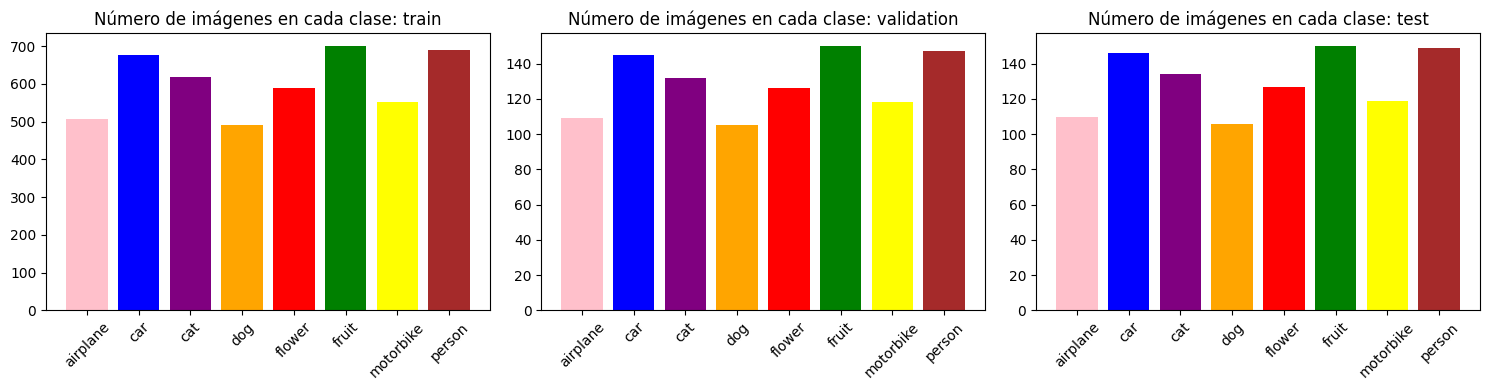

In [5]:
data = ["train", "validation", "test"]
folder = [train_folder, val_folder, test_folder]
color = ['pink', 'blue', 'purple', 'orange', 'red', 'green', 'yellow', 'brown']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
axes = axes.ravel()
for i, ax in enumerate(axes):
    num_images, classes = get_num_images(folder[i])
    print(f"Datos de {data[i]}: {np.array(num_images).sum()} imágenes")
    ax.figure
    ax.bar(classes, num_images, color=color)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f"Número de imágenes en cada clase: {data[i]}")
plt.tight_layout()
plt.show()

Tenemos un conjunto de datos balanceado. Hay más o menos la misma cantidad de cada clase en cada conjunto de entrenamiento, validación y prueba.

#### Librería Pillow (PIL) (https://python-pillow.org/)

Librería para el procesamiento de imágenes. Vamos a usar Pillow para leer y mostrar las imágenes

Tamaño de la imágen:  (128, 128)


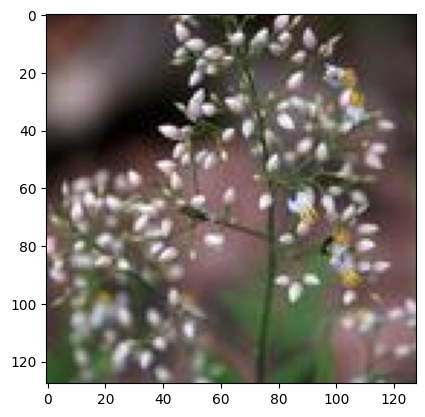

In [6]:
# Ver un ejemplo de una de las imágenes
# Leer la imagen con Pillow (PIL)
image = Image.open(os.path.join(train_folder, 'flower/flower_0403.jpg'))
print("Tamaño de la imágen: ", image.size)
plt.imshow(image)
plt.show()

#### Los píxeles 

Las imágenes se componen de una matriz de números entre 0 (negro) y 255 (blanco). Estos números se llaman píxeles.

Las imágenes de color tienen 3 canales (rojo, verde, azul) y las imágenes en escala gris tienen 1 canal.

![pixels](image_pixels.png)

In [7]:
# Ver los valores de los píxeles
# Tiene formato (H x W x C) (altura, ancho, canales)
numpy_image = np.asarray(image)
print(numpy_image.shape)
print('valor máximo de los píxeles: ', numpy_image.max())
print('valor mínimo de los píxeles: ', numpy_image.min())

(128, 128, 3)
valor máximo de los píxeles:  255
valor mínimo de los píxeles:  0


In [8]:
# Valores de píxeles en la imagen
numpy_image

array([[[57, 33, 29],
        [57, 33, 29],
        [58, 33, 29],
        ...,
        [34, 31, 22],
        [31, 28, 19],
        [30, 27, 18]],

       [[60, 36, 32],
        [61, 36, 32],
        [62, 37, 33],
        ...,
        [35, 32, 23],
        [32, 29, 20],
        [30, 27, 18]],

       [[65, 40, 35],
        [66, 41, 36],
        [68, 40, 36],
        ...,
        [36, 33, 26],
        [33, 30, 23],
        [32, 29, 22]],

       ...,

       [[50, 89, 42],
        [49, 88, 41],
        [48, 86, 39],
        ...,
        [91, 73, 71],
        [86, 71, 68],
        [83, 68, 65]],

       [[51, 90, 45],
        [49, 88, 43],
        [47, 85, 38],
        ...,
        [85, 74, 68],
        [83, 72, 66],
        [81, 70, 64]],

       [[52, 91, 46],
        [50, 89, 44],
        [47, 85, 38],
        ...,
        [78, 69, 62],
        [77, 68, 61],
        [76, 67, 60]]], dtype=uint8)

In [9]:
# Número total de píxeles = 128 x 128 x 3

print("Número total de píxeles en la imagen :", numpy_image.shape[0] * numpy_image.shape[1] * numpy_image.shape[2])

Número total de píxeles en la imagen : 49152


### Aumento de imágenes con transformaciones

Para hacer tranformaciones de imágenes en PyTorch, usamos `torchvision.transforms.v2` o `torchvision.transforms`. 

`v2` es la nueva versión. Aunque está todavía en beta, PyTorch recomienda que usamos `v2`.

**Formato de entrada:** se puede usar imágenes tipo PIL (pillow) o tensores 

- Imágenes en formato tensor tienen la forma **(C, H, W)** dónde **C** es el número de canales y **H** y **W** son la altura y ancho respectivamente. 

- Para entradas en batches, la forma será **(N, C, H, W)**, dónde **N** es le número de imágenes en el batch.

Hay muchas transformaciones que se puede aplicar: https://pytorch.org/vision/stable/transforms.html

In [10]:
# Mostrar la imagen original junto con la imagen transformada
def plot_images(image, image_trans, title, title_trans):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,10))
    ax[0].imshow(image)
    ax[0].set_title(title)
    ax[1].imshow(image_trans)
    ax[1].set_title(title_trans)
    plt.show()

#### Cambiar el tamaño de la imágen

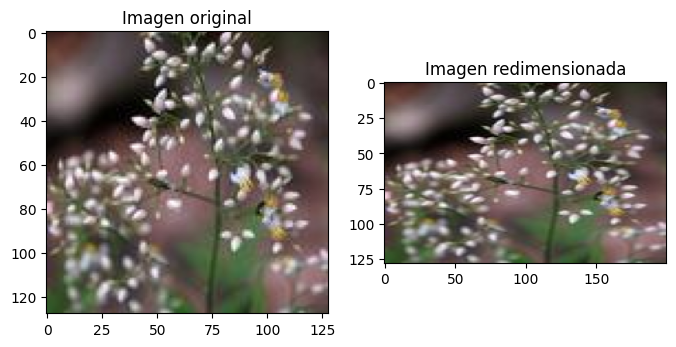

In [11]:
transforms = v2.Compose([
   v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imágen es en formato PIL
   v2.Resize(size=(128, 200), antialias=True), # Cambiar el tamaño a 128 x 200
   v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

resize_image = transforms(image)

plot_images(image, resize_image, 'Imagen original', 'Imagen redimensionada')

#### Voltear horizonalmente la imagen 

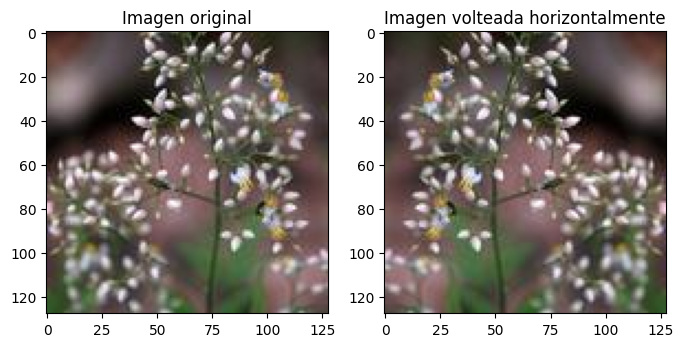

In [12]:
transforms = v2.Compose([
   v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
   v2.RandomHorizontalFlip(p=1), # p=1 probabilidad de voltear es 1. Se puede cambiar a 0.5 para voltear solamente la mitad de las imágenes
   v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen volteada horizontalmente')

#### Voltear verticalmente la imagen

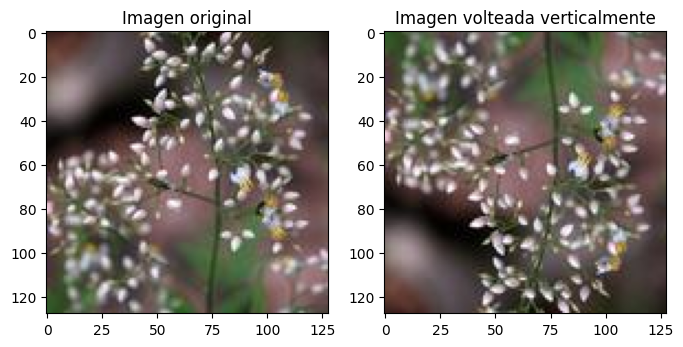

In [13]:
transforms = v2.Compose([
   v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
   v2.RandomVerticalFlip(p=1), # p=1 probabilidad de voltear es 1. Se puede cambiar a 0.5 para voltear solamente la mitad de las imágenes
   v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen volteada verticalmente')

#### Transformar los colores

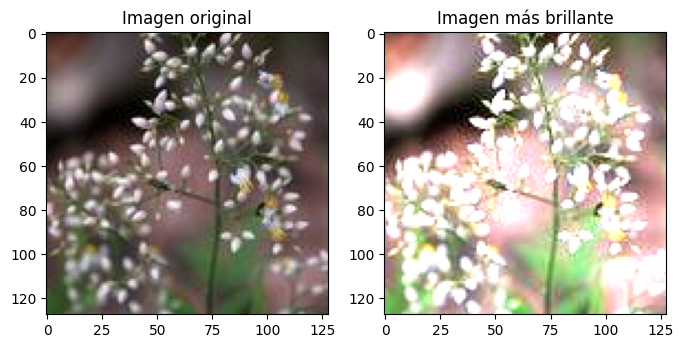

In [14]:
transforms = v2.Compose([
   v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
   v2.ColorJitter(brightness=3), # parametro brightness determina qué tan brillante es la imagen 
   v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen más brillante')

#### Delimitar la imagen

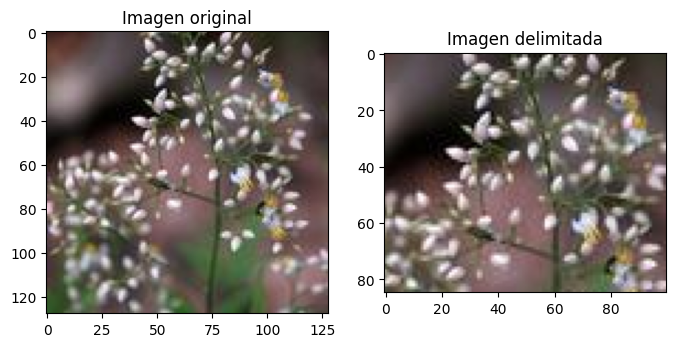

In [15]:
transforms = v2.Compose([
   v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
   v2.RandomCrop(size=(85,100)), # size especifica el tamaño nuevo de la imagen 
   v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen delimitada')

#### Rotar la imagen

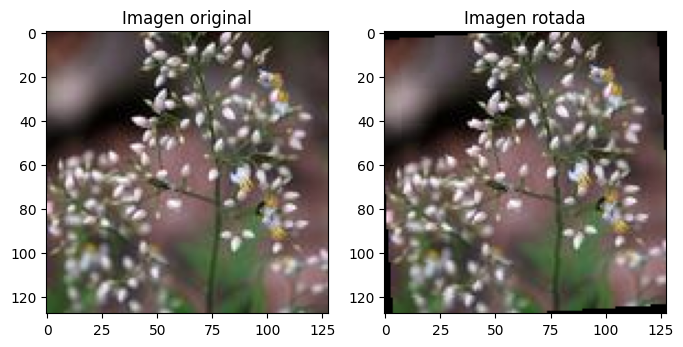

In [16]:
transforms = v2.Compose([
   v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
   v2.RandomRotation(degrees=60), # degrees especifica cuánto rotar la imagen 
   v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen rotada')

#### Normalizar la imagen

Normalizar una imagen con una media y desviación estándar especifica.

Hay tres valores para la media y desviación estándar ya que la imagen contiene 3 canales

**Transformación:** (valor del píxel - valor media para el canal)/desviación estándear para el canal

In [17]:
transforms = v2.Compose([
   v2.ToImage(),
   v2.ToDtype(torch.float32, scale=True),  # Cambiar el formato de los números a float y escalarlo entre 0 y 1
   v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalizar la imagen entre -1 y 1. Algunos modelos quieren: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] 
])

normalize_image = transforms(image)

In [18]:
# Valores de la imagen escalada
numpy_image = np.asarray(normalize_image)
print(numpy_image.shape)
print('valor máximo de los píxeles: ', numpy_image.max())
print('valor mínimo de los píxeles: ', numpy_image.min())
print('valor medio de los píxeles: ', numpy_image.mean())

(3, 128, 128)
valor máximo de los píxeles:  1.0
valor mínimo de los píxeles:  -1.0
valor medio de los píxeles:  -0.2468614


In [19]:
# Escalar los píxeles entre 0 y 1
scaled_image = np.asarray(image) / 255 # dividir los píxeles por 255
print(scaled_image.shape)
print('valor máximo de los píxeles: ', scaled_image.max())
print('valor mínimo de los píxeles: ', scaled_image.min())
print('valor medio de los píxeles: ', scaled_image.mean())

(128, 128, 3)
valor máximo de los píxeles:  1.0
valor mínimo de los píxeles:  0.0
valor medio de los píxeles:  0.37656928168402776


#### Incluir transformaciones en el entrenamiento

**Hay 2 maneras de incluir transformaciones en el entrenamiento:**

1. Aumentar el conjunto de datos de entrenamiento añadiendo imágenes con transformaciones al conjunto de datos de entrenamiento. (por ejemplo aumentar la cantidad de las imágenes por 25%)

2. Aplicar transformaciones (aleatoriamente) durante el entrenamiento a las imágenes en el conjunto de datos.

** Las transformaciones se aplica a los datos de entrenamiento ya que ayuda el modelo a aprender

** Para los datos de validación y prueba no aplicamos las transformaciones ya que queremos saber el rendimiento en nuestros datos (no en datos transformados)

In [20]:
transforms_train = v2.Compose([
        v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
        v2.RandomHorizontalFlip(0.5), # Voltear la imagen horizontalmente con probabilidad 0.5
        v2.RandomVerticalFlip(0.3), # Voltear la imagen verticalmente con probabilidad 0.3
        v2.ToDtype(torch.float32, scale=True), # Cambiar el formato de los números a float y escalarlo entre 0 y 1
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalizar los píxeles entre -1 y 1
    ])

In [21]:
transforms_evaluate = v2.Compose([
        v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
        v2.ToDtype(torch.float32, scale=True),  # Cambiar el formato de los números a float y escalarlo entre 0 y 1
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalizar los píxeles entre -1 y 1
    ])

### Crear el Dataset y el DataLoader

**ImageFolder**

PyTorch tiene un tipo de Dataset que se llama `ImageFolder` que se puede usar con imagenes si las imagenes están estructuradas en la siguiente manera:

```
root/
├── dog
│   ├── xxx.jpg
│   ├── xxy.jpg
│   └── xxz.jpg
│       
└── cat
    ├── 123.jpg
    ├── 234.jpg
    └── ...
    └── 456.jpg
 
```

Como nuestros datos tienen esta estructura, podemos usar esta clase para almanecer las imagenes.

Especificamos los siguientes parámetros para ImageFolder:

1. `root`: ruta del directorio raíz

2. `transform`: función/transformación que toma como entrada una imagen PIL y devuelve la imagen transformada

In [22]:
train_dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=transforms_train)
val_dataset = torchvision.datasets.ImageFolder(root=val_folder, transform=transforms_evaluate)
test_dataset = torchvision.datasets.ImageFolder(root=test_folder, transform=transforms_evaluate)

In [23]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4826
    Root location: natural_images_classification/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 RandomHorizontalFlip(p=0.5)
                 RandomVerticalFlip(p=0.3)
                 ToDtype(scale=True)
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [24]:
val_dataset

Dataset ImageFolder
    Number of datapoints: 1032
    Root location: natural_images_classification/validation
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [25]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1041
    Root location: natural_images_classification/test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

#### Crear el DataLoader

In [26]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Ejemplos de las imágenes 

In [27]:
# Poner la imagen en el formato que necesitamos
def img_display(img):
    img = img / 2 + 0.5     # deshacer normalización
    npimg = img.numpy()     # cambiar al tipo numpy array (de tipo tensor)
    npimg = np.transpose(npimg, (1, 2, 0)) # poner las dimensiones en el orden que necesita matplotlib (H x W x C) en vez de (C x H x W)
    return npimg

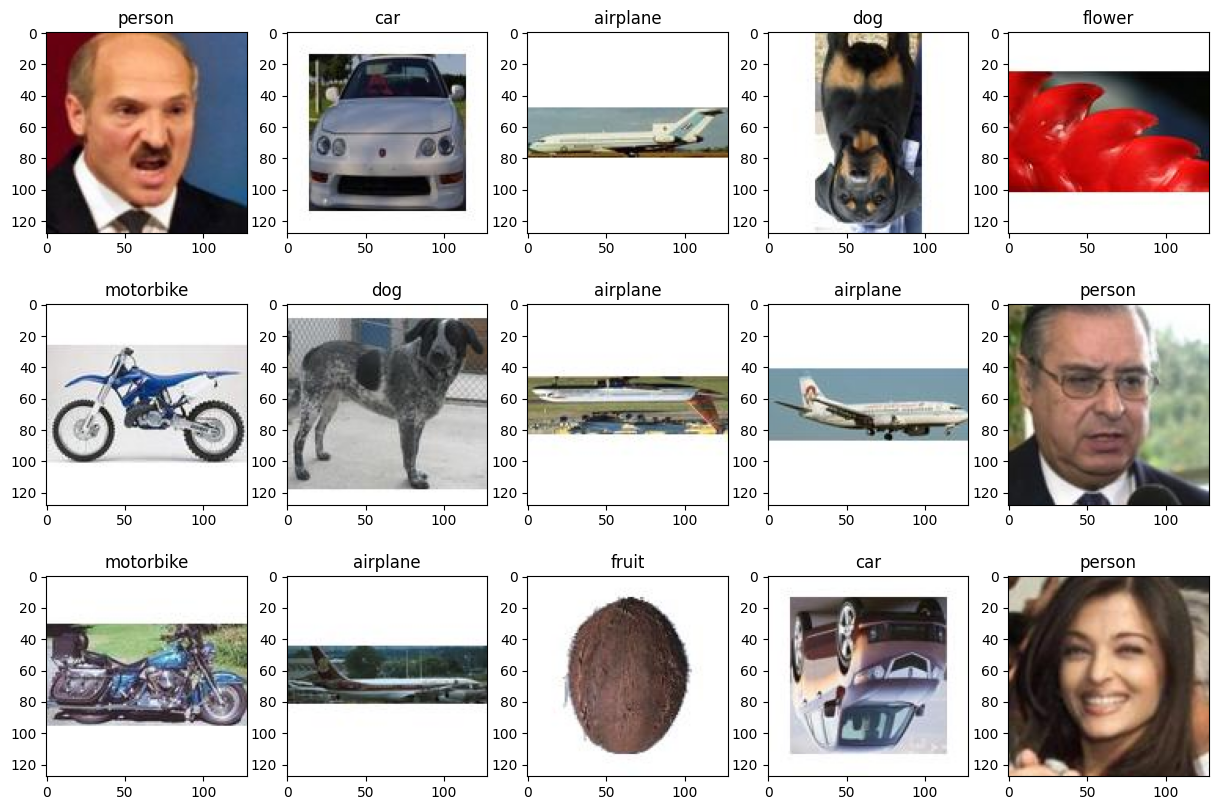

In [28]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # mostrar imagen
        ax.set(title = classes[label.item()]) # añadir etiqueta


### Definir la red convolucional

![conv_net](conv_net.png)

1. capas convolucionales

2. capas de pooling (agrupación)

3. capas totalmente conectadas

#### Capas convolucionales

PyTorch: Conv2d (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

- Aplica una convolución de 2D sobre los datos de entrada

- Parametros: in_channels, out_channels, kernel_size, stride, padding


#### Kernel_size

- El producto escalar se calcula entre el kernel (núcleo) y un región de los datos de entrada que es del tamaño del kernel

- El resultado de este product escalar pasa a formar parte del mapa de características de salida

- El tamaño del kernel normalmente es pequeño (por ejemplo, 3x3, 5x5)

![kernel](kernel_size.png)

#### Stride

El número de píxeles para desplazar el núcleo cada vez que se aplica el producto escalar

![stride](stride.png)

#### Padding

Se aplica para evitar perder información en los bordes

![padding](padding.png)

#### Tamaño de la salida

Salida = [(H (altura) - kernel_size + 2 * padding)/stride + 1] x [(W (ancho) - kernel_size + 2 * padding)/stride + 1] x out_channels (número de filtros)

In [29]:
# Ejemplo de una capa convolucional

simple_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1), # in_channel es 3 ya que tenemos imagenes en color
)


In [30]:
# Salida = [(128 - 3 + 2*1)/1 + 1] x [(128 - 3 + 2*1)/1 + 1] x 12 = 128 x 128 x 12

for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break


images.shape: torch.Size([64, 3, 128, 128])
out.shape: torch.Size([64, 12, 128, 128])


In [31]:
# Ejemplo de una capa convolucional

simple_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=18, kernel_size=7, stride=1, padding=1), # in_channel es 3 ya que tenemos imagenes en color
)


In [32]:
# Salida = [(128 - 7 + 2*1)/1 + 1] x [(128 - 7 + 2*1)/1 + 1] x 12 = 124 x 124 x 18

for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break


images.shape: torch.Size([64, 3, 128, 128])
out.shape: torch.Size([64, 18, 124, 124])


In [33]:
# Ejemplo de una capa convolucional

simple_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0), # in_channel es 3 ya que tenemos imagenes en color
)


In [34]:
# Salida = [(128 - 3 + 2*0)/1 + 1] x [(128 - 3 + 2*0)/1 + 1] x 12 = 126 x 126 x 12

for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([64, 3, 128, 128])
out.shape: torch.Size([64, 12, 126, 126])


In [35]:
# Ejemplo de una capa convolucional

simple_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=2, padding=0), # in_channel es 3 ya que tenemos imagenes en color
)

In [36]:
# Salida = [(128 - 3 + 2*0)/2 + 1] x [(128 - 3 + 2*0)/2 + 1] x 12 = 63 x 63 x 12 (62.5 se redondea a 62)

for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([64, 3, 128, 128])
out.shape: torch.Size([64, 12, 63, 63])


#### Capas de pooling

Reduce el tamaño del mapa de características de salida reemplazando los valores de las salidas cercanas con estadísticas resumidas

PyTorch: nn.MaxPool2d (https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

![pooling](pooling.png)

In [37]:
simple_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=2, stride=2),
)

In [38]:
# Salida_Conv2d = [(128 - 3 + 2*1)/1 + 1] x [(128 - 3 + 2*1)/1 + 1] x 12 = 128 x 128 x 12
# Salida_MaxPool2d = [(128 - 2)/2 + 1] x [(128 - 2)/2 + 1] x 12 = 64 x 64 x 12

for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([64, 3, 128, 128])
out.shape: torch.Size([64, 12, 64, 64])


### Crear el modelo

- capa convolucional: 12 filtros, tamaño del kernel = 3, stride = 1, padding = 1

- capa pooling: tamaño del kernel = 2, stride = 2

- función de activación ReLU

- capa convolucional: 24 filtros, tamaño del kernel = 3, stride = 1, padding = 1

- capa pooling: tamaño del kernel = 2, stride = 2

- función de activación ReLU

- capa lineal: 8 neuronas (tenemos 8 clases)

- LogSoftmax (convertir la salida a probabilidades logarítmicas)
    - Softmax convierte la salida probabilidades (que en total suman a 1)
    - usamos LogSoftmax en vez de Softmax que convierte la salida a probabilidades porque es mejor para la eficiencia computacional y la optimización del gradiente

In [39]:
# Crear nuestra red convolucional
class ImagePredictor(nn.Module):
    
    # Defining the Constructor
    def __init__(self, num_classes):
        super(ImagePredictor, self).__init__()
        # En la función de init definimos todas las capas que vamos a usar en nuestro modelo

        self.network = nn.Sequential(
        # Nuestras imágenes son color, así que tenemos 3 canales y aplicamos 12 filtros
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1),
            # Conv2d salida = [(128-3+2*1)/1+1] x [(128-3+2*1)/1+1] x 12 = 128 x 128 x 12
            nn.MaxPool2d(kernel_size=2, stride=2),
            # MaxPool2d salida = [(128-2+2*0)/2+1] x [(128-2+2*0)/1+1] x 12 = 64 x 64 x 12
            nn.ReLU(),
            # ReLU función de activación después de capa 1 (convolucional y pool)

        # La segunda capa convolucional tiene datos de entrada con 12 canales y genera 24 canales 
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1),
            # Conv2d salida = [(64-3+2*1)/1+1] x [(64-3+2*1)/1+1] x 24 = 64 x 64 x 24
            nn.MaxPool2d(kernel_size=2, stride=2),
            # MaxPool2d salida = [(64-2+2*0)/2+1] x [(64-2+2*0)/1+1] x 24 = 32 x 32 x 24
            nn.ReLU(),
            # ReLU función de activación después de capa 2 (convolucional y pool)
        
        # Necesitamos cambiar las dimensiones para poner las caracteristicas a traves de una capa totalmente conectada
            nn.Flatten(),
            # Usamos una capa totalmente conectada para predecir probabilidades
            nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)
        )

    def forward(self, x):
        # In esta función pasamos los datos a traves de las capas que definimos en la función init 
        x = self.network(x)
        # Devolver las probabilidades para cada clase con la función log_softmax
        return torch.log_softmax(x, dim=1)

In [40]:
# Especificamos que queremos usar una GPU si está disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/colleen.mcmillon/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [41]:
# Initializar el modelo y mandarlo a la GPU 
model = ImagePredictor(num_classes=len(classes)).to(device)

print(model)

ImagePredictor(
  (network): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=24576, out_features=8, bias=True)
  )
)


In [42]:
for i_batch, (x_train, y_train) in enumerate(train_loader):
    print("número de batch :", i_batch)
    print("x_train en i_batch : ", x_train.size())
    print("y_train en i_batch :", y_train.size())
    break

# Vemos que son los outputs del modelo - probabilidades en este caso
outputs = model(x_train.to(device))
print("-----------------------------")
print("Probabilidades logarítmicas")
print("-----------------------------")
print(outputs)
print(outputs.shape)
print("-----------------------------")
print("Clase predicha")
print("-----------------------------")
_,pred = torch.max(outputs, dim=1)
print(pred)
print(pred.shape)


número de batch : 0
x_train en i_batch :  torch.Size([64, 3, 128, 128])
y_train en i_batch : torch.Size([64])
-----------------------------
Probabilidades logarítmicas
-----------------------------
tensor([[-1.9048, -2.0137, -2.0721, -2.1106, -2.0288, -2.1716, -2.1343, -2.2374],
        [-1.8765, -2.0601, -2.0528, -2.1597, -2.1144, -2.1098, -1.9983, -2.3212],
        [-1.8815, -2.0012, -2.1361, -2.0497, -2.0615, -2.1610, -2.1077, -2.2869],
        [-1.9521, -2.1057, -2.0628, -2.1642, -2.0375, -2.1404, -1.9887, -2.2119],
        [-1.9578, -2.0038, -2.0545, -2.0912, -2.0874, -2.0459, -2.1435, -2.2849],
        [-2.0217, -2.0222, -2.1148, -2.0819, -2.0297, -2.1549, -2.0867, -2.1331],
        [-1.8127, -2.0613, -2.1271, -2.1907, -1.9620, -2.1337, -2.0777, -2.3614],
        [-1.8931, -2.0136, -2.1500, -2.1163, -2.0011, -2.2341, -2.0170, -2.2673],
        [-1.8644, -1.9698, -2.1630, -2.1044, -2.1099, -2.0803, -2.1903, -2.2018],
        [-1.8826, -2.0733, -2.0794, -2.1293, -2.0315, -2.1534, -

### Especificar función de coste y optimizador 

In [43]:
# Especificar tasa de aprendizaje
learning_rate = 0.01

# Usamos el optimizador Adam 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Especificar la función de coste 
loss_criteria = nn.CrossEntropyLoss()

### Definir las funciones para el entrenamiento y validación 

In [44]:
# Función para el entrenamiento de una época
def train(model, device, train_loader, optimizer, loss_criteria):
    # Pon modelo en modo para entrenar
    model.train()

    # Especificar variables para las metricas
    epoch_loss = 0
    elements = 0
    correct = 0
    
    # Procesar las imágenes en batches (lotes)
    for i_batch, (image, label) in enumerate(train_loader):
       
        # Mover los datos al GPU (si estamos usandolo)
        image, label = image.to(device), label.to(device)
        
        # Pon a cero los gradientes para cada batch 
        # No mezclar información de los gradientes del batch anterior con este batch
        optimizer.zero_grad()
        
        # Calcular la salida del modelo
        outputs = model(image)
        
        # Calcular las perdidas y el coste # Get the loss
        batch_loss = loss_criteria(outputs, label)

        # Calcular los gradientes 
        batch_loss.backward()

        # Ajustar los parametros (pesos y sesgos)
        optimizer.step()

        # Guardar las metricas
        epoch_loss += batch_loss.item()

        # Calcular cuantos han sido predicho correctamente
        _, predicted = torch.max(outputs.data, 1)
        correct += torch.sum(label==predicted).item()
        elements += len(label)


    # Calcular la metrica para la época entera
    loss_train = epoch_loss / i_batch
    acc_train = correct / elements

    return loss_train, acc_train

In [45]:
# Función para la validación de una época
def evaluation(model, val_loader, loss_criteria):
    # Pon modelo en modo para evaluar
    model.eval()

    # Especificar variables para las metricas
    epoch_loss = 0
    elements = 0
    correct = 0

    # No queremos calcular los gradientes
    with torch.no_grad():
         
         # Procesar las imágenes en batches (lotes)
         for i_batch, (image, label) in enumerate(val_loader):
            
            # Mover los datos al GPU (si estamos usandolo)
            image, label = image.to(device), label.to(device)

            # Calcular la salida del modelo
            outputs = model(image)

            # Calcular las perdidas y el coste
            batch_loss = loss_criteria(outputs, label)

            # Guardar las metricas
            epoch_loss += batch_loss.item()
            
            # Seleccionar la clase con la probabilidad más alta
            _, predicted = torch.max(outputs.data, 1)
            
            # Calcular cuantos han sido predicho correctamente
            correct += torch.sum(label==predicted).item()
            elements += len(label)
    
    # Calcular la metrica para la época entera
    loss_val = epoch_loss / i_batch
    acc_val = correct / elements

    return loss_val, acc_val

In [46]:
def training_evaluation_loop(epochs, model, train_loader, val_loader, optimizer, loss_criteria):
    # Iniciar temporizador para realize un seguimiento del tiempo de entrenamiento
    start = time.time()
    
    # Crear listas para las metricas
    loss_values_train = []
    acc_values_train = []
    loss_values_val = []
    acc_values_val = []

    for epoch in range(epochs):
        
        # Ejecutar función de entrenamiento y guardar las metricas
        loss_train, acc_train = train(model, device, train_loader, optimizer, loss_criteria)
        loss_values_train.append(loss_train)
        acc_values_train.append(acc_train)

        # Ejecutar función de validación y guardar las metricas
        loss_val, acc_val = evaluation(model, val_loader, loss_criteria)
        loss_values_val.append(loss_val)
        acc_values_val.append(acc_val)

        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss_train:.5f}, Train Accuracy: {acc_train:.5f} | Validation Loss: {loss_val:.5f}, Val Accuracy: {acc_val:.5f}')
        
    end = time.time()
    total_time = end - start

    print(f'Total training time: {total_time}')

    return loss_values_train, acc_values_train, loss_values_val, acc_values_val

**Ejecutar el bucle**

`epochs`: número de veces que el modelo ve el conjunto de datos de entrenamiento completo

In [47]:
epochs = 10
loss_values_train, acc_values_train, loss_values_val, acc_values_val = training_evaluation_loop(epochs, model, train_loader, val_loader, optimizer, loss_criteria)


Epoch:    0 | Train Loss: 1.31895, Train Accuracy: 0.63531 | Validation Loss: 0.59317, Val Accuracy: 0.79457
Epoch:    1 | Train Loss: 0.54736, Train Accuracy: 0.79486 | Validation Loss: 0.40930, Val Accuracy: 0.83915
Epoch:    2 | Train Loss: 0.38038, Train Accuracy: 0.85392 | Validation Loss: 0.34211, Val Accuracy: 0.86531
Epoch:    3 | Train Loss: 0.33566, Train Accuracy: 0.87754 | Validation Loss: 0.31122, Val Accuracy: 0.87500
Epoch:    4 | Train Loss: 0.28553, Train Accuracy: 0.89121 | Validation Loss: 0.33454, Val Accuracy: 0.87112
Epoch:    5 | Train Loss: 0.29975, Train Accuracy: 0.88790 | Validation Loss: 0.31039, Val Accuracy: 0.88081
Epoch:    6 | Train Loss: 0.25254, Train Accuracy: 0.90220 | Validation Loss: 0.30346, Val Accuracy: 0.87888
Epoch:    7 | Train Loss: 0.24349, Train Accuracy: 0.90303 | Validation Loss: 0.30895, Val Accuracy: 0.87209
Epoch:    8 | Train Loss: 0.26046, Train Accuracy: 0.90240 | Validation Loss: 0.35750, Val Accuracy: 0.87209
Epoch:    9 | Train

### Evaluación 

Curvas de aprendizaje tráves de las épocas

- Pèrdidas

- Precisión

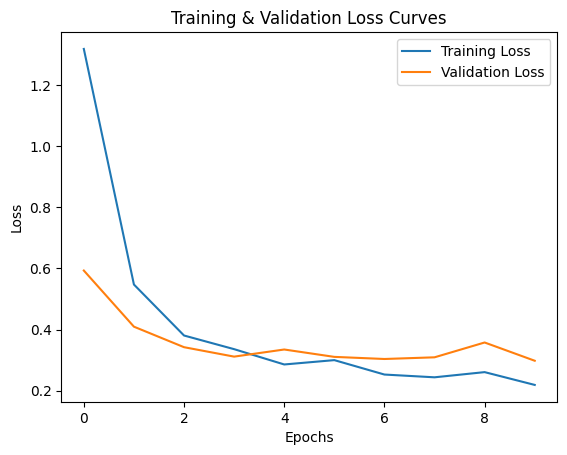

In [48]:
plt.plot(list(range(epochs)), loss_values_train, label='Training Loss')
plt.plot(list(range(epochs)), loss_values_val, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

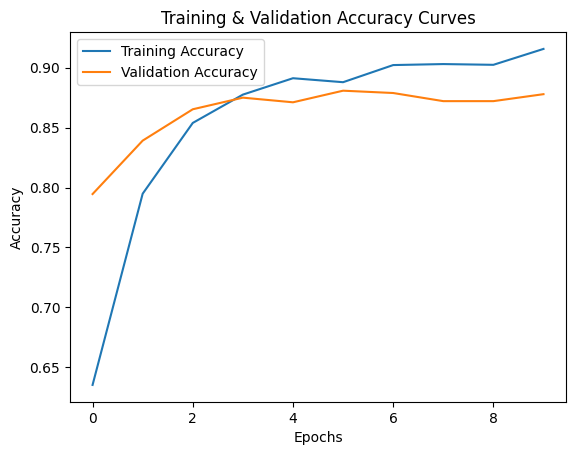

In [49]:
plt.plot(list(range(epochs)), acc_values_train, label='Training Accuracy')
plt.plot(list(range(epochs)), acc_values_val, label='Validation Accuracy')
plt.title('Training & Validation Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Probar el conjunto de prueba en el modelo

Evaluar el rendimiento del modelo con datos que no ha visto previamente.

- Mètrica de precisión

- Matriz de confusión 

In [50]:
def predictions(model, test_loader):

    # Crear listas para los valores predichos y reales
    predictions = []
    true_labels = []

    correct = 0
    # Pon modelo en modo para evaluar
    model.eval()
     # No queremos calcular los gradientes
    with torch.no_grad():
        for image, label in test_loader:

            # Mover los datos al GPU (si estamos usandolo)
            image, label = image.to(device), label.to(device)

            # Calcular la salida del modelo
            outputs = model(image)

            # Seleccionar la clase con la probabilidad más alta
            _, predicted = torch.max(outputs.data, 1)

            # Calcular cuantos han sido predicho correctamente
            correct += torch.sum(label==predicted).item()

            # Mover los datos al CPU y cambiar el tipo a numpy en vez de tensor
            predictions.append(predicted.detach().cpu().numpy())
            true_labels.append(label.detach().cpu().numpy())
    
    # Poner los datos en el formato que los necesitamos        
    predictions = np.hstack(predictions)
    true_labels = np.hstack(true_labels)

    print(f'Test set has accuracy of: {correct/len(true_labels)*100}%') # test_loader

    return predictions, true_labels

In [51]:
# Ejecutar la función para generar las predicciones para los datos de prueba
predictions, true_labels = predictions(model, test_loader)

Test set has accuracy of: 87.41594620557157%


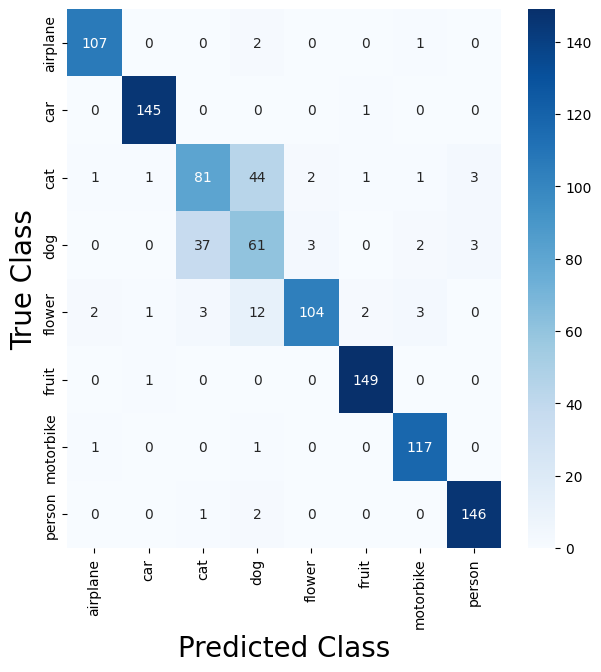

In [52]:
# Matriz de confusión
cm = confusion_matrix(true_labels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Class", fontsize = 20)
plt.ylabel("True Class", fontsize = 20)
plt.show()